In [10]:
from keras.applications import VGG19,inception_v3
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
def vgg19():
    # VGG16 model
    vgg_conv = VGG19(weights="imagenet",
                 include_top = False,
                 input_shape=(224,224,3))
    
    return vgg_conv

def in_v3_model():
    in_v3 = inception_v3.InceptionV3(weights="imagenet",
                         include_top=False,
                         input_shape=(299,299,3)) 
    
    return in_v3    

In [12]:
def pred_generator_features(model, generator, batch_size, feature_size):
    sample_size = len(generator.filenames)
    class_num = len(generator.class_indices.keys())
#    pred_features = np.zeros(shape=(sample_size, 8, 8, 2048))
    pred_features = np.zeros(shape=(sample_size, feature_size[0], feature_size[1], feature_size[2]))
    labels = np.zeros(shape=(sample_size, class_num))
    i = 0
    
    # predict training features
    for input_batch, labels_batch in generator:
        features_batch = model.predict(input_batch)
        pred_features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        
        if i * batch_size >= sample_size:
            break
    pred_features = np.reshape(pred_features, (sample_size, feature_size[0]*feature_size[1]*feature_size[2]))
    
    return [pred_features, labels]

In [13]:
def get_train_features(pre_trained_model, target_size, feature_size, train_dir): 
    batch_size = 20
    
    # generator training data from directory
    datagen = ImageDataGenerator(rescale=1./255)
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=batch_size,
        class_mode="categorical")
    
    np.save('25_class_indices_in_v3', train_generator.class_indices)
    
    
    # training features and training lables
    [train_features, train_labels] = pred_generator_features(pre_trained_model,
                                             train_generator,
                                             batch_size,
                                             feature_size)
    
    
    return [train_features, train_labels]

In [14]:
def cnn_model(train_features,
              train_labels,
              epochs=20,
              batch_size=20,
              validation_split=0.2):
    classifier = models.Sequential()
    classifier.add(layers.Dense(256, activation='relu', input_dim=train_features.shape[1]))
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(25, activation='softmax'))
    
    classifier.compile(optimizer=optimizers.RMSprop(lr=2e-4),
                       loss='categorical_crossentropy',
                       metrics = ['accuracy'])
    
    history = classifier.fit(train_features,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split)
    
    classifier.save('small_in_v3.h5')
    
    plot_figure(history)
    
    return classifier

In [15]:
def plot_figure(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    
    plt.show()

In [16]:
def model_training(pre_trained_model, target_size, feature_size, train_dir):
    [train_features, train_labels] = get_train_features(pre_trained_model,target_size,feature_size, train_dir)
    cnn_model(train_features, train_labels)

In [17]:
def prediction(pre_trained_model, target_size, cnn_model, pred_dir, class_indices):
    # e.g. {13: "green_bean_cake"}
    idx_2_label = dict((v,k) for k, v in class_indices.items())
    
    # scan predicions directory
    with os.scandir(pred_dir) as it:
        for cat in it:
            if cat.is_dir():
                with os.scandir(cat.path) as sub:
                    for file in sub:
                        if file.name.find(".DS_Store") < 0:
                            
                            img = load_img(file.path, target_size=target_size)
                            plt.imshow(img)
                            plt.show()
                            
                            img_numpy = img_to_array(img) / 255
                            
                            img_numpy = img_numpy.reshape(1, target_size[0], target_size[1],3)
                            
                            pred_feature = pre_trained_model.predict(img_numpy).reshape(1, -1)
            
                            pred = np.argmax(cnn_model.predict(pred_feature))
                            print(f'{cat.name} predicted as {pred}: {idx_2_label[pred]}')
    

Found 1750 images belonging to 25 classes.
Train on 1400 samples, validate on 350 samples
Epoch 1/20
1400/1400 [==============================] - 6s 5ms/step - loss: 11.4174 - acc: 0.1900 - val_loss: 3.1150 - val_acc: 0.6086
Epoch 2/20
1400/1400 [==============================] - 3s 2ms/step - loss: 2.2299 - acc: 0.6414 - val_loss: 0.5853 - val_acc: 0.8371
Epoch 3/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.8576 - acc: 0.8264 - val_loss: 0.2853 - val_acc: 0.9543
Epoch 4/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5190 - acc: 0.9036 - val_loss: 0.2696 - val_acc: 0.9429
Epoch 5/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.4776 - acc: 0.9064 - val_loss: 0.1624 - val_acc: 0.9657
Epoch 6/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.4129 - acc: 0.9279 - val_loss: 0.2886 - val_acc: 0.9486
Epoch 7/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3490 - acc: 0.9436 - val_lo

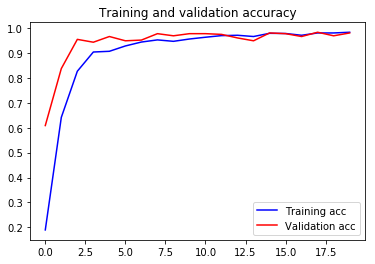

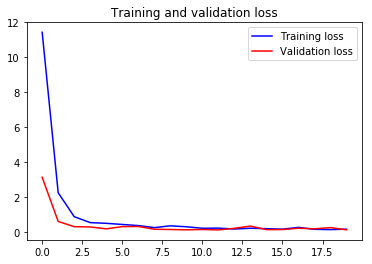

In [18]:
if __name__ == "__main__":
    
    # inception_v3 model
    in_v3 = in_v3_model()
    train_dir = "./small_images"
    
    model_training(in_v3, (299, 299), (8, 8, 2048), train_dir)

In [ ]:
 # prediction
    
class_indices = np.load("./25_class_indices_in_v3.npy").item()
model = models.load_model("./small_in_v3.h5")
prediction(in_v3, (299, 299), model, "./predictions", class_indices)